In [1]:
# enable plots in the notebook
import matplotlib.pyplot as plt
# makes our plots prettier
import seaborn
seaborn.set(style='ticks')

#import the audio playback widget
from IPython.display import Audio
from scipy import signal

# useful librairies
import mir_eval
import numpy as np
import scipy
import librosa
import librosa.display
from pydub import AudioSegment 
from ModulationPy import PSKModem, QAMModem

import wave
from scipy.io import wavfile
import contextlib

In [2]:
from turtle import *
import math


"""
Description :
- Accepte toutes les dimensions de dessin (dans la limite du raisonnable, ne pas dépasser 30x30 pixel).
- PAR EXEMPLE pour dessiner le logo ESIEE, utilisez un fichier txt contenant ceci :

111110011111001000111110011111
110000011000001100110000011000
111110011111001100011110011111
110000000011001100110000011000
111110011111001100111110011111

- Ne pas oublier de fermer turtle avec la commande, bye().

"""


#dessin d'un pixel
def dessinerPixel(x , y):
    fillcolor("black")
    up()
    goto(x,y)
    down()
    begin_fill()
    for i in range(4):
        forward(20)
        left(90)
    end_fill()



#dessine l'image a partir du fichier txt mis en parametre
def dessinerASCII(nomFichier):
    #Variables
    x =-300
    y = 100

    #parametres du stylo
    speed(15)
    delay(0)
    hideturtle()

    fichier = open(nomFichier, "r")
    lignes = fichier.readlines()
    for ligne in lignes:
        for bit in ligne:
            if(bit == "1"):
                dessinerPixel(x , y)
            x+=20
        y-=20
        x=-300
    print("dessin terminé")

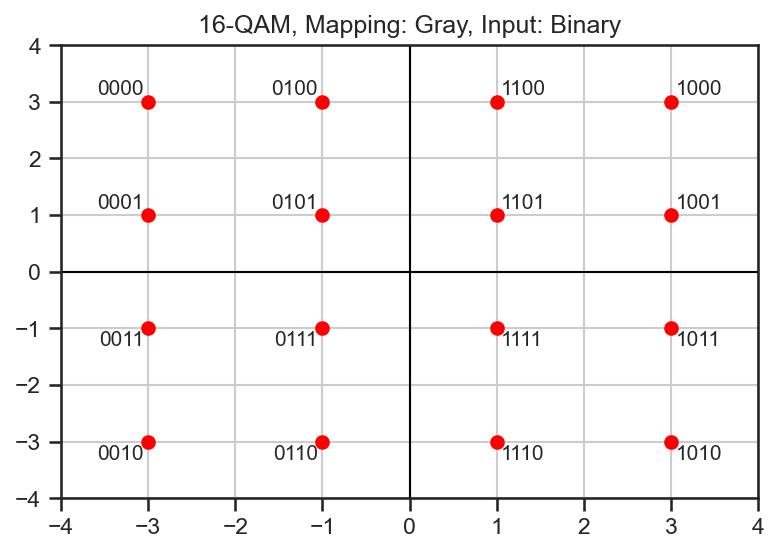

In [3]:
modem = QAMModem(16, 
                 bin_input=True,
                 soft_decision=False,
                 bin_output=True)
modem.plot_const()

In [114]:
def binaire(s):
    ords = (ord(c) for c in s)
    shifts = (7, 6, 5, 4, 3, 2, 1, 0)
    return [(o >> shift) & 1 for o in ords for shift in shifts]

def char(bits):
    chars = []
    for b in range(int(len(bits) / 8)):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

texte = "Interstellar prend comme point de départ un futur proche ressemblant à s’y méprendre au notre. L’humanité est confrontée a une crise écologique majeure. La Terre ne peut plus nourrir ses habitants, non pas à cause de la surpopulation (non évoquée) mais en raison de la mort des espéces végétales. Le blé et d’autres céréales ont disparues, dévorées par des parasites. Les hommes tombent malades à cause d’une poussière permanente et de terribles tempêtes de sable. Au fur et à mesure, on découvre que le gouvernement américain (et le reste du monde), a pris un virage radical proche du soviétisme : la plupart de gens deviennent agriculteurs, la technique devient suspecte et tout ce qui est coûteux en énergie et matériel est abandonné. Les programmes spatiaux sont stoppés, les agences spatiales fermées, et c’est le cas aussi pour des techniques médicales comme l’IRM. Le message du film est clair : le refus de la technique peut conduire l’humanité à sa mort. Seul espoir de survie de l’humanité : la conquête de l’espace et la migration de l’humanité vers une autre planète. Mais comment faire alors que la conquête spatiale est au point mort ?"
texte_bin = binaire(texte) #Texte convertit en binaire
texte_binaire = np.array(texte_bin)#Permet de convertir list en array

#image = np.array([1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0]) # message d'entrée

msg = np.concatenate((texte_binaire,image)) #msg = image + texte que l'on souhaite transmettre 

print(msg[160:170])
print(texte_binaire[0:10])
print(len(texte))
print(msg.shape)
print(image.shape)
print(texte_binaire.shape)

[0 1 1 0 1 1 1 1 0 1]
[0 1 0 0 1 0 0 1 0 1]
1149
(9352,)
(160,)
(9192,)


In [115]:
modulation = modem.modulate(msg) # modulation -> Moduler un tableau de bits en symboles de constellation
print ( " Message modulé : \n " + str (modulation)+ "\n")

 Message modulé : 
 [-1.+3.j  3.+1.j -1.-3.j ...  1.-3.j -1.-1.j  1.+3.j]



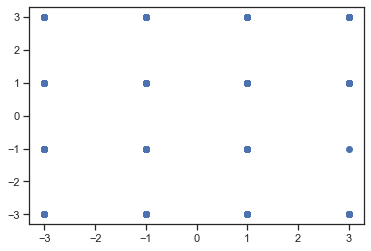

In [116]:
symbols_real = modulation.real
symbols_imag = modulation.imag
plt.scatter(symbols_real,symbols_imag)

In [117]:
#Etape 2 : convolution
import scipy
from commpy.filters import rcosfilter

Tsymbol = 0.0001875*100  # pour correspondre à la durée du sample 

# Débit binaire D = log2(M)/Tsymbol = n/Tsymbol = 21,333 kbps
# augmenter le Tsymbol revient à diminuer le débit binaire D

# B>= (1+ alpha)/Tsymbol --> Tsymbol >= 0.1875 ms

Fsamp = 44100
alpha = 1/2
N = int(5*Tsymbol*Fsamp)
delta_symbols = np.zeros(len(modulation)*int(Tsymbol*Fsamp),dtype =complex)
delta_symbols[::int(Tsymbol*Fsamp)]= modulation

4134


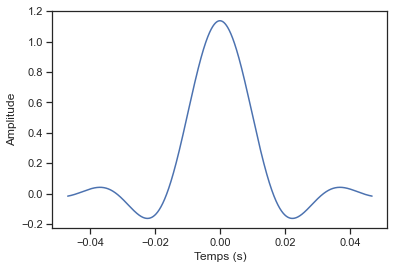

In [118]:
import scipy
from commpy.filters import rrcosfilter
temps, h_rc = rrcosfilter(N, alpha, Tsymbol, Fsamp)
print(len(h_rc))
plt.plot(temps, h_rc)
plt.ylabel('Amplitude')
plt.xlabel('Temps (s)')

plt.show()

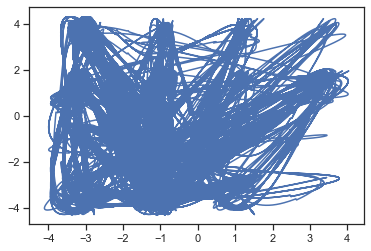

In [80]:
convo = np.convolve(delta_symbols , h_rc, mode="same") 
#print(convo)
plt.figure()
plt.plot(np.real(convo), np.imag(convo))

In [119]:
Fp =16000 
#Fréquence porteuse = milieu de la bande passante


# linspace permet d’obtenir un tableau 1D allant d’une valeur de départ (ordre croissant)
# à une valeur de fin avec un nombre donné d’éléments.

# valeur de départ --> 0
# valeur d'arrivée --> 20.71555555
# nbr valeurs dans tableau --> 913556
t=np.linspace(0 ,np.size(convo)/Fsamp,np.size(convo))
son = np.real(convo*np.exp(2*np.pi*1j*Fp*t))

In [121]:
zu, sigma = 0,1
z = np.random.normal(zu,sigma,np.size(son))

son_emetteur_noise = son + z

random_desynch = np.random.randint(1,100)
vzeros = np.zeros(random_desynch,dtype = int)
son_recepteur = np.concatenate([vzeros,son_emetteur_noise])

In [122]:
Fp = 16000 #Fréquence porteuse
t = np.linspace(0,np.size(son_recepteur)/Fsamp, np.size(son_recepteur)) 

I_reel = 2*son_recepteur*np.cos(2*np.pi*Fp*t) #composante réel en phase 
Q_quadrature = -2*son_recepteur*np.sin(2*np.pi*Fp*t) #composante réel en quadrature


# Vérification son et son2 : normal de ne pas avoir les mêmes valeurs. 
# --> supprimer facteurs 2 de I_reel et Q_quadrature
son2 = I_reel*np.cos(2*np.pi*Fp*t)-Q_quadrature*np.sin(2*np.pi*Fp*t)
print(son)
print(son2) 

[-1.49766951 -1.43822228  3.36816384 ... -0.0247084   0.30481823
 -0.37449158]
[0.         0.         0.         ... 4.18953829 0.04508742 0.62198063]


In [123]:
I = np.convolve (I_reel, h_rc,'same')
Q = np.convolve (Q_quadrature, h_rc,'same')

[1181.59310275-365.47873347j 1183.60534164-368.3266473j
 1185.59942338-371.18996825j ...  127.24266573-147.38880045j
  125.73712548-145.44436442j  124.29350138-143.48401036j]
[-1.49766951+3.17625108j -1.49548388+3.17690518j -1.49327315+3.17754466j
 ... -0.14505663-0.34993428j -0.14579105-0.35219247j
 -0.14651885-0.35443349j]


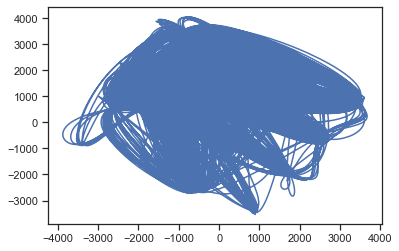

In [124]:
x_t = I+1j*Q #signal complexe en bande de base
print (x_t)
print(convo)
plt.figure()
plt.plot(np.real(x_t),np.imag(x_t))

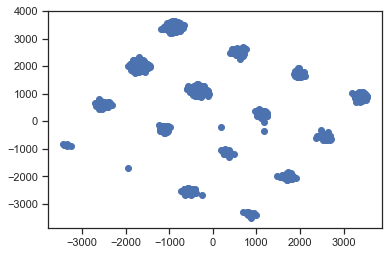

In [125]:
sans_synchro = x_t[::int(Tsymbol*Fsamp)]
plt.figure()
plt.scatter(np.real(sans_synchro), np.imag(sans_synchro))

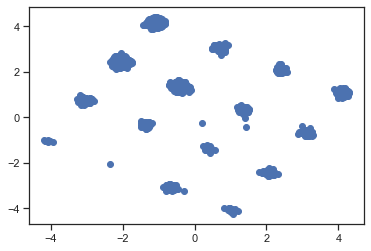

In [126]:
convo_ss = np.convolve(h_rc,h_rc,'same')
Mconvo_ss =np.max(convo_ss)

div_ss =sans_synchro/Mconvo_ss

plt.figure()
plt.scatter(np.real(div_ss), np.imag(div_ss))

In [127]:
texte_corr="Interstellar prend comme point de départ un futur proche ressemblant à s’y méprendre au notre."
texte_bin_corr = binaire(texte_corr) #Texte convertit en binaire
texte_binaire_corr = np.array(texte_bin_corr)
msg_test = modem.modulate(texte_binaire_corr)


delta_symbols_corr = np.zeros(len(msg_test)*int(Tsymbol*Fsamp),dtype =complex)
delta_symbols_corr[::int(Tsymbol*Fsamp)]= msg_test

In [128]:
s_BB_oh = np.convolve(delta_symbols_corr, h_rc, mode="same") 

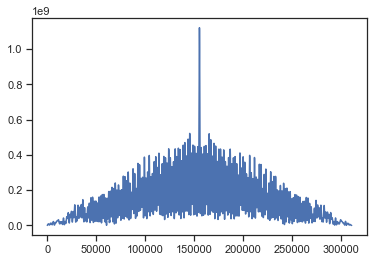

In [129]:
correl = scipy.signal.correlate(s_BB_oh,x_t[:np.size(s_BB_oh)])

plt.figure()
plt.plot(np.abs(correl))


In [130]:
rshift = np.size(s_BB_oh)-np.argmax(np.abs(correl))
print(rshift)

36


In [131]:
corr_alpha =[]
A = np.linspace(0,1,1000)
for alpha in A :
    r_BB_coh_oh = x_t[rshift:(np.size(s_BB_oh)+rshift)]*np.exp(2j*np.pi*alpha)
    R = np.corrcoef(np.real(r_BB_coh_oh),np.real(s_BB_oh))
    corr_alpha.append((R[0,1]))
    
ccc = np.argmax(corr_alpha)
print(ccc)

335


[-231.18734436+1317.52064515j 2413.17715298 +998.98550489j
 -859.97050548-2516.42967187j ...  796.59441978-2407.80579368j
 -920.92746626 -825.18543218j  817.00800797+2463.41638101j]


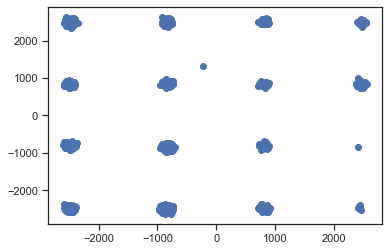

In [132]:
test = x_t[rshift:]*np.exp(2j*np.pi*A[ccc])
test2 = test[::int(Fsamp*Tsymbol)]

print(test2)
plt.figure()
plt.scatter(np.real(test2),np.imag(test2))

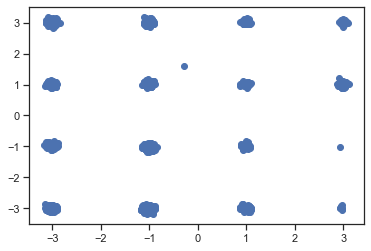

In [133]:
convo2 = np.convolve(h_rc,h_rc,'same')
Mconvo2 =np.max(convo2)

div =test2/Mconvo2

plt.figure()
plt.scatter(np.real(div), np.imag(div))

In [136]:
demodulation = modem.demodulate(div) # modulation -> Moduler un tableau de bits en symboles de constellation
print ( " Message modulé : \n " + str (demodulation)+ "\n")



 Message modulé : 
 [0. 1. 0. ... 1. 0. 0.]



In [140]:
def convDemod(demodulation):
    """
    ENTREE : Prend en parametre le résultat de la démodulation du signal.
    AFFICHAGE : Affiche l'image et la phrase transmise en appelant les fonctions précédentes.
    SORTIE : Enregistre un fichier "resultat.txt" dans le dossier courant contenant l'image, et la phrase en binaire.
    
    """
    #variables :
    h = 0
    l = 0
    
    f = open('resultat.txt', 'w')    
    c=0
    for i in range(16):
        f.write(str(demodulation[i])[0])
        c += 1
        if(c==8):
            f.write("\n")
            c = 0
            
    for i in range(demodulation.size - 16):
        f.write(str(demodulation[i+16])[0])
    f.close()
    
    
    
    f = open('resultat.txt', 'r') 
    lignes = f.readlines()
    
    c = 0
    for ligne in lignes:
        c += 1
        if(c == 1):
            l = ligne
        if(c == 2):
            h = ligne
    
    f.close()
    
    f = open('resultat.txt', 'w') 
    
    l = int(l, base = 2)
    h = int(h, base = 2)
    
    c = 0
    p = 0
    for i in range(demodulation.size - 16):
        c += 1
        f.write(str(demodulation[i+16])[0])
        if(c==l and p<5):
            f.write("\n")
            p += 1
            c = 0
            
    f.close()
     
    #dessinerASCII('resultat.txt', h)
    
    fichier = open('resultat.txt', "r")
    lignes = fichier.readlines()
    texte = char(lignes[h])
    print("Phrase interprétée : " + texte)
        
    
    
    """""
    #debug
    print(l)
    print(h)
    print(type(l), type(h))
    """
    
    f.close()